In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv("student_habits_performance.csv")
print("Shape of dataset:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())

Shape of dataset: (1000, 16)

First 5 rows:
   student_id  age  gender  study_hours_per_day  social_media_hours  \
0      S1000   23  Female                  0.0                 1.2   
1      S1001   20  Female                  6.9                 2.8   
2      S1002   21    Male                  1.4                 3.1   
3      S1003   23  Female                  1.0                 3.9   
4      S1004   19  Female                  5.0                 4.4   

   netflix_hours part_time_job  attendance_percentage  sleep_hours  \
0            1.1            No                   85.0          8.0   
1            2.3            No                   97.3          4.6   
2            1.3            No                   94.8          8.0   
3            1.0            No                   71.0          9.2   
4            0.5            No                   90.9          4.9   

  diet_quality  exercise_frequency parental_education_level internet_quality  \
0         Fair                   

In [7]:
print("Summary:\n", df.describe())

Summary:
              age  study_hours_per_day  social_media_hours  netflix_hours  \
count  1000.0000           1000.00000         1000.000000    1000.000000   
mean     20.4980              3.55010            2.505500       1.819700   
std       2.3081              1.46889            1.172422       1.075118   
min      17.0000              0.00000            0.000000       0.000000   
25%      18.7500              2.60000            1.700000       1.000000   
50%      20.0000              3.50000            2.500000       1.800000   
75%      23.0000              4.50000            3.300000       2.525000   
max      24.0000              8.30000            7.200000       5.400000   

       attendance_percentage  sleep_hours  exercise_frequency  \
count            1000.000000  1000.000000         1000.000000   
mean               84.131700     6.470100            3.042000   
std                 9.399246     1.226377            2.025423   
min                56.000000     3.200000    

Perfect ✅ this dataset is **great for Linear / Polynomial Multivariate Regression**.

We want to predict **`exam_score` (target variable)** using the other features.

### 🔧 Step 2: Preprocessing Plan

Since we **can’t use sklearn**, we’ll manually handle preprocessing. Here’s what we’ll do:

1. **Drop unnecessary columns**

   * `student_id` is just an identifier → drop it.

2. **Handle categorical variables (objects → numbers)**

   * `gender` → Male/Female
   * `part_time_job` → Yes/No
   * `diet_quality` → Good/Fair/Poor
   * `parental_education_level` → categories
   * `internet_quality` → Poor/Average/Good
   * `extracurricular_participation` → Yes/No

   👉 We’ll convert these using **one-hot encoding manually**.

3. **Feature scaling (optional, but helps in gradient descent)**

   * Normalize numerical features like `study_hours_per_day`, `attendance_percentage`, `sleep_hours`, etc.

In [17]:
print(df.columns)
# df = df.drop("student_id", axis = 1)
cate_cols =["gender", "part_time_job", "diet_quality", "parental_education_level", "internet_quality", "extracurricular_participation"]
df_encoded = pd.get_dummies(df, columns = cate_cols, drop_first = True)
print("Shape after encoding:", df_encoded.shape)
print("\nColumns after encoding:\n", df_encoded.columns)
print(df_encoded.head())

Index(['age', 'gender', 'study_hours_per_day', 'social_media_hours',
       'netflix_hours', 'part_time_job', 'attendance_percentage',
       'sleep_hours', 'diet_quality', 'exercise_frequency',
       'parental_education_level', 'internet_quality', 'mental_health_rating',
       'extracurricular_participation', 'exam_score'],
      dtype='object')
Shape after encoding: (1000, 20)

Columns after encoding:
 Index(['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
       'attendance_percentage', 'sleep_hours', 'exercise_frequency',
       'mental_health_rating', 'exam_score', 'gender_Male', 'gender_Other',
       'part_time_job_Yes', 'diet_quality_Good', 'diet_quality_Poor',
       'parental_education_level_High School',
       'parental_education_level_Master', 'parental_education_level_None',
       'internet_quality_Good', 'internet_quality_Poor',
       'extracurricular_participation_Yes'],
      dtype='object')
   age  study_hours_per_day  social_media_hours  netf

In [19]:
X = df_encoded.drop("exam_score", axis = 1).values
Y = df_encoded["exam_score"].values.reshape(-1, 1)
print("Feature matrix shape:", X.shape)  # Expect (1000, 19)
print("Target shape:", Y.shape)          # Expect (1000,)

Feature matrix shape: (1000, 19)
Target shape: (1000, 1)


In [22]:
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
split = int(0.8*len(indices))
train_index, test_index = indices[:split], indices[split:]

x_train, x_test = X[train_index], X[test_index]
y_train, y_test = Y[train_index], Y[test_index]

In [23]:
mean_X = np.mean(x_train, axis = 0)
std_X = np.std(x_train, axis = 0)

x_train = (x_train-mean_X)/std_X
x_test = (x_test-mean_X)/std_X

Great question 👍 Let’s break this down carefully.

You have this code:

```python
# add column of 1s for bias
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]  # (m, n+1)
X_test  = np.c_[np.ones((X_test.shape[0], 1)), X_test]    # (m, n+1)
```

---

### 1. Why do we add a column of **1s**?

In **linear regression** (or most linear models), the hypothesis is:

$$
y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n
$$

Here:

* $\theta_0$ = **bias** (intercept term)
* $\theta_1, \theta_2, \dots, \theta_n$ = weights for features

If we keep $\theta_0$ separate, we need special handling. Instead, we **include it in the weight vector** by adding a constant feature = 1.

So it becomes:

$$
y = \theta_0 \cdot 1 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n
$$

Now, the formula is simply:

$$
y = X \cdot \theta
$$

---

### 2. What does the code do?

```python
np.ones((X_train.shape[0], 1))
```

👉 Creates a column vector of all `1`s with shape `(m, 1)`
(where `m` = number of training samples).

```python
np.c_[ ... ]
```

👉 `np.c_` concatenates arrays **column-wise**.

So:

* Before:
  `X_train.shape = (m, n)` (m samples, n features)

* After:
  `X_train.shape = (m, n+1)`
  because we added 1 extra column of all `1`s at the **beginning**.

Example:

```python
X_train = [[2, 3],
           [4, 5],
           [6, 7]]
```

After adding bias column:

```python
X_train = [[1, 2, 3],
           [1, 4, 5],
           [1, 6, 7]]
```

---

### 3. Why important?

Now the first weight in `theta` corresponds to the **bias term** automatically.

So:

* `theta[0]` → bias
* `theta[1:]` → actual feature weights

This makes the math much cleaner during gradient descent.


In [24]:
x_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
x_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]

Great—you’ve basically written **batch gradient descent** for multivariate linear regression. Let me explain each part, point out a few bugs, and give you a cleaned-up version.

---

## What your function is doing

```python
def desc(X, Y, lr = 0.01, epochs = 10000):
    m,n = X.shape                  # m = samples, n = features (incl. bias column)
    theta = np.zeros(n, 1)         # ❌ bug: wrong shape/usage

    for i in range(epochs):
        y_pred = X.dot(theta)      # (m,n) @ (n,1) -> (m,1)
        error = y_pred - Y         # residuals (m,1)
        grad = (1/m)*X.T.dot(error)# gradient (n,1)
        theta = theta - lr*grad     # update rule

        if epoch % 100 == 0:       # ❌ bug: 'epoch' undefined; should use 'i'
            cost = (1/(2*m)) * np.sum(error ** 2)  # MSE/2
            print(f"Epoch {epoch}, Cost: {cost:.4f}")
    return theta
```

### Math behind it

* Model: $\hat{y} = X \theta$ (make sure you already added a **bias column of 1s** in `X`)
* Loss: $J(\theta) = \frac{1}{2m} \sum_{i=1}^m (\hat{y}_i - y_i)^2$
* Gradient: $\nabla_\theta J = \frac{1}{m} X^\top (X\theta - y)$
* Update: $\theta \leftarrow \theta - \alpha \cdot \nabla_\theta J$ where `alpha = lr`

---

## Issues/bugs to fix

1. **Theta init shape**

```python
theta = np.zeros(n, 1)  # ❌
theta = np.zeros((n, 1))  # ✅ needs a tuple
```

2. **Use consistent shapes**

* Ensure `Y` is a **column vector**: `Y.shape == (m, 1)`
  If you pass `(m,)`, broadcasting may bite you. Do: `Y = Y.reshape(-1,1)`.

3. **Undefined variable**

* You print with `epoch` but your loop variable is `i`. Use `i`.

4. **Optional but important: scaling**

* For stable/fast convergence, standardize features beforehand (mean 0, std 1). You already did/know this, but it’s crucial.

---

## Cleaned-up, robust version

```python
def gradient_descent(X, y, lr=0.01, epochs=10000, verbose_every=500):
    """
    Batch gradient descent for multivariate linear regression.

    Parameters
    ----------
    X : array-like, shape (m, n)
        Feature matrix. MUST already include a bias (intercept) column of 1s.
    y : array-like, shape (m,) or (m,1)
        Target values.
    lr : float
        Learning rate (step size).
    epochs : int
        Number of iterations.
    verbose_every : int or None
        Print cost every 'verbose_every' steps if not None.

    Returns
    -------
    theta : ndarray, shape (n,1)
        Learned parameters (first entry = bias weight).
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1, 1)

    m, n = X.shape
    theta = np.zeros((n, 1))

    for epoch in range(epochs):
        y_pred = X @ theta              # (m,1)
        error = y_pred - y              # (m,1)
        grad  = (X.T @ error) / m       # (n,1)
        theta = theta - lr * grad

        if verbose_every and (epoch % verbose_every == 0 or epoch == epochs-1):
            cost = (error**2).sum() / (2*m)
            print(f"Epoch {epoch:5d} | Cost: {cost:.6f}")

    return theta
```

### Notes

* **Bias**: Make sure you did

  ```python
  X = np.c_[np.ones((X.shape[0], 1)), X]
  ```

  before calling `gradient_descent`.
* **Learning rate**: If cost diverges or becomes `nan`, lower `lr` (e.g., 0.001). If convergence is slow, try a bit higher (e.g., 0.05), but watch stability.
* **Evaluation**:

  ```python
  y_hat = X_test @ theta
  mse = np.mean((y_test.reshape(-1,1) - y_hat)**2)
  r2  = 1 - ((y_test.reshape(-1,1) - y_hat)**2).sum() / ((y_test.reshape(-1,1) - y_test.mean())**2).sum()
  ```

If you want, I can also add **cost history** (to plot learning curve) or an **early stopping** condition (stop when improvement is tiny).


In [33]:
def desc(X, Y, lr = 0.01, epochs = 10000):
    m,n = X.shape
    theta = np.zeros((n, 1))
    
    for i in range(epochs):
        y_pred = X.dot(theta)
        error = y_pred-Y
        grad = (1/m)*X.T.dot(error)
        theta = theta - lr*grad
        
        if i % 1000 == 0:
            cost = (1/(2*m)) * np.sum(error ** 2)
            print(f"Epoch {i}, Cost: {cost:.4f}")
    return theta




### 1. Shape of **theta**

In your gradient descent:

```python
theta = np.zeros((n, 1))   # column vector
```

So,

$$
\theta =
\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\theta_2 \\
\vdots \\
\theta_n
\end{bmatrix}
\quad \in \mathbb{R}^{n \times 1}
$$

This is a **column vector** (n rows, 1 column).

---

### 2. What is **theta.T**

In NumPy, `.T` means **transpose** (swap rows and columns).

So,

$$
\theta^T =
\begin{bmatrix}
\theta_0 & \theta_1 & \theta_2 & \dots & \theta_n
\end{bmatrix}
\quad \in \mathbb{R}^{1 \times n}
$$

That is a **row vector**.

---

### 3. Why it matters

* **Column vector form (n×1)** is convenient for multiplication with $X$:

  $$
  X \cdot \theta \quad \text{gives predictions.}
  $$

  Because $X$ is $(m \times n)$ and $\theta$ is $(n \times 1)$, the product is $(m \times 1)$.

* **Row vector form (1×n)** is useful if you want to print parameters side-by-side or multiply in a different orientation (like $\theta^T x$ for a single sample vector $x$).

---

### 4. Quick example in Python

```python
import numpy as np

theta = np.array([[1],
                  [2],
                  [3]])
print("theta shape:", theta.shape)
print(theta)

print("theta.T shape:", theta.T.shape)
print(theta.T)
```

**Output:**

```
theta shape: (3, 1)
[[1]
 [2]
 [3]]

theta.T shape: (1, 3)
[[1 2 3]]
```

---

👉 So, **`theta` is a column vector of parameters, and `theta.T` is its row-vector transpose**.
They’re mathematically the same numbers, just oriented differently for matrix operations.

In [36]:
theta = desc(x_train, y_train)
print("Learned Parameters:", theta.T)

Epoch 0, Cost: 2587.9166
Epoch 1000, Cost: 13.1860
Epoch 2000, Cost: 13.1860
Epoch 3000, Cost: 13.1860
Epoch 4000, Cost: 13.1860
Epoch 5000, Cost: 13.1860
Epoch 6000, Cost: 13.1860
Epoch 7000, Cost: 13.1860
Epoch 8000, Cost: 13.1860
Epoch 9000, Cost: 13.1860
Learned Parameters: [[ 6.99076250e+01 -1.82339426e-01  1.41731907e+01 -2.73335139e+00
  -2.47164550e+00  1.30087146e+00  2.33344567e+00  2.99712081e+00
   5.26490518e+00  8.49877894e-02  9.99875418e-02  1.74191868e-01
  -2.30809385e-01 -1.99615455e-01 -1.82081999e-01 -9.74399757e-02
  -1.74706563e-01 -4.32485682e-01 -8.60334335e-03  4.33237741e-02]]


In [37]:
y_pred = x_test.dot(theta)

mse = np.mean((y_pred - y_test) ** 2)
print("Test MSE:", mse)

# R^2 Score (goodness of fit)
ss_total = np.sum((y_test - np.mean(y_test))**2)
ss_res = np.sum((y_test - y_pred)**2)
r2 = 1 - (ss_res / ss_total)
print("R^2 Score:", r2)

Test MSE: 35.80956448920266
R^2 Score: 0.8662767258681751


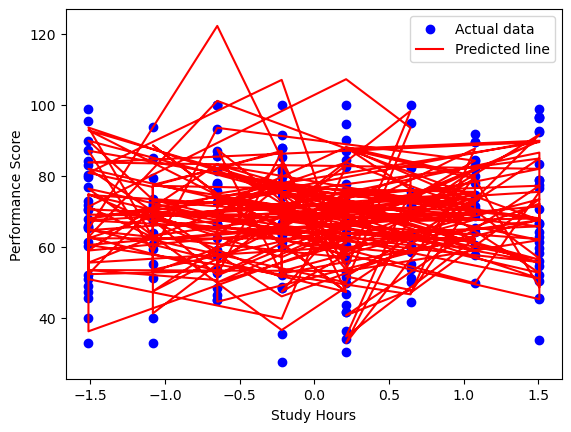

In [40]:
import matplotlib.pyplot as plt


# Predictions on training set
y_pred = x_test.dot(theta)

# Plot actual data points
plt.scatter(x_test[:,1], y_test, color="blue", label="Actual data")  # X[:,1] since col 0 is bias
# Plot predicted line
plt.plot(x_test[:,1], y_pred, color="red", label="Predicted line")

plt.xlabel("Study Hours")
plt.ylabel("Performance Score")
plt.legend()
plt.show()


In [42]:
# Predictions on test data
y_test_pred = x_test.dot(theta)

# MSE
mse = np.mean((y_test - y_test_pred) ** 2)

# R2 score
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
ss_res = np.sum((y_test - y_test_pred) ** 2)
r2 = 1 - (ss_res / ss_total)

print("MSE:", mse)
print("R2 Score:", r2)
print("Accuracy (%):", r2 * 100)

MSE: 35.80956448920266
R2 Score: 0.8662767258681751
Accuracy (%): 86.62767258681751
